# Step 1: Import lib

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as torch # core lib for deep learning methods
import time as time   # maybe I will use time to test how long a piece of code takes
import numpy as np    # it's likely that we use numpy to perform matrix manipulation
import cv2 as cv      # image I/O
import os as os

# Step 2: Build custom class for the dataset
* ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Custom Dataset needs at least the following 3 methods:
    1. `__init__`: This function is run once when instantiating the Dataset object.
    2. `__len__`: This function returns the number of samples in our dataset.
        * At least, dataloader will need to call this function.
    3. `__getitem__`: This function loads and returns a sample from the dataset at the given index (i.e., `idx`).

In [2]:
from torch.utils.data import Dataset

class CAT_DOG_DATASET(Dataset):
    
    def __init__(self, img_dir, img_size, x_transform=None, y_transform=None):
        
        self.img_dir = img_dir
        self.img_size = img_size
        self.x_transform = x_transform
        self.y_transform = y_transform
        
        self.imgs = os.listdir(self.img_dir)
        self.len = len(self.imgs)
        self.ans_list = list()
        self.img_path_list = list()
        self.__loop_through_dir__()

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        
        # input: image
        img_path = self.img_path_list[idx]
        image = self.__preprocess__(img_path)
#         image = cv.imread(img_path)
#         image = cv.resize(image, (img_size, img_size))
#         image = image / 255.
#         if self.x_transform:
#             image = self.x_transform(image)
        
#         image = image.reshape(3, img_size, img_size)
        
        # output: label
        label = self.ans_list[idx]
        if self.y_transform:
            label = self.y_transform(label)
        
        return image, label
    
    def __preprocess__(self, img_path):
        
        image = cv.imread(img_path)
        image = cv.resize(image, (img_size, img_size))
        image = image / 255.
        
        # channel first
        if self.x_transform:
            image = self.x_transform(image)
        
        image = image.reshape(3, img_size, img_size)
        return image
    
    def __loop_through_dir__(self):

        cat_count = 0
        dog_count = 0
        for img_name in tqdm(self.imgs):

            img_path = self.img_dir + img_name
            self.img_path_list.append(img_path)

            ans = img_name.split(".")[0]
            if ans == "cat":
                self.ans_list.append(0)
                cat_count = cat_count + 1
            else: # ans == "dog"
                self.ans_list.append(1)
                dog_count = dog_count + 1
        print(f"# of cats: {cat_count}")
        print(f"# of dogs: {dog_count}")


# Step 3: Hyperparamter setting

In [3]:
learning_rate = 1e-4
batch_size = 128
epochs = 30
model_path = './model/CNN_model_weights.pth'
train_dir_path = "../../Dataset/Cat_and_Dog/train/train/"
img_size = 128

# Step 4: Setup dataloader

In [4]:
from torch.utils.data import DataLoader

tran_dataset = CAT_DOG_DATASET(img_dir=train_dir_path, img_size=img_size)
tran_loader = DataLoader(tran_dataset, batch_size=batch_size, shuffle=True)

100%|██████████████████████████████████████| 25000/25000 [00:00<00:00, 1236499.14it/s]

# of cats: 12500
# of dogs: 12500


# Step 5: Get device for training
* ref: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Step 6: Define the class (for model)
* `nn.Conv2d`: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
* `nn.Linear`: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
* [calculator](https://madebyollin.github.io/convnet-calculator/) for `width`, `height`, `channels`, `stride`, `padding`

In [6]:
from torch import nn

class CNN_v1(nn.Module):
    
    def __init__(self, img_size): # I add one more param here, i.e., img_size, for changing CNN structure auto
        super(CNN_v1, self).__init__()
        
        self.img_size = img_size # assume (B, C=3, H=256, W=256)
        
        self.cspec = [3, 64, 128, 256, 512, 1024, 512, 256] # cspec stands for conv spec
        self.fspec = [128, 64, 1] # fspec stands for fully connected layer spec

        self.repeat_conv = nn.Sequential(

            # 換換不同的寫法 v1
            nn.Conv2d(
                in_channels = self.cspec[0],
                out_channels = self.cspec[1],
                kernel_size = (3, 3), # this could be tuple, i.e., (3,3), or just integer i.e., 3.
                stride = 2, # based on the calculator mentioned above, this setting will make spatial size half
                padding = 1 
            ),
            nn.ReLU(),                   # (B, C=  64, H=128, W=128)
            nn.BatchNorm2d(self.cspec[1]),
            #nn.MaxPool2d(kernel_size=2), # (B, C=  64, H= 64, W= 64)

            # 換換不同的寫法 v2
            nn.Conv2d(in_channels=self.cspec[1], out_channels=self.cspec[2], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 128, H= 64, W= 64)
            nn.BatchNorm2d(self.cspec[2]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 128, H= 32, W= 32)
            
            nn.Conv2d(in_channels=self.cspec[2], out_channels=self.cspec[3], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 256, H= 32, W= 32)
            nn.BatchNorm2d(self.cspec[3]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 256, H= 16, W= 16)
            
            nn.Conv2d(in_channels=self.cspec[3], out_channels=self.cspec[4], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 512, H= 16, W= 16)
            nn.BatchNorm2d(self.cspec[4]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 512, H=  8, W=  8)
            
            nn.Conv2d(in_channels=self.cspec[4], out_channels=self.cspec[5], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C=1024, H=  8, W=  8)
            nn.BatchNorm2d(self.cspec[5]),
            #nn.MaxPool2d(kernel_size=2), # (B, C=1024, H=  4, W=  4)
        
            nn.Conv2d(in_channels=self.cspec[5], out_channels=self.cspec[6], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 512, H=  4, W=  4)
            nn.BatchNorm2d(self.cspec[6]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 512, H=  2, W=  2)
            
            nn.Conv2d(in_channels=self.cspec[6], out_channels=self.cspec[7], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 256, H=  2, W=  2)
            nn.BatchNorm2d(self.cspec[7]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 256, H=  1, W=  1)
        )

        self.flatten = nn.Flatten()

        # 需要優化 #
        C = 256
        H = 1
        W = H # assume square
        self.repeat_dense = nn.Sequential(
            nn.Linear(in_features= C*H*W, out_features=self.fspec[0]),
            nn.ReLU(),
            nn.Linear(in_features= self.fspec[0], out_features=self.fspec[1]),
            nn.ReLU(),
            nn.Linear(in_features= self.fspec[1], out_features=self.fspec[2]),
        )
                    
    def forward(self, img):
        feature_map = self.repeat_conv(img)
        features = self.flatten(feature_map)
        logits = self.repeat_dense(features)
        return logits
    
def test():
    batch_size = 10
    channel_num = 3
    img_size = 128

    CNN_model = CNN_v1(img_size=img_size)
    
    # Usually use torch.randn to test if model can work as expected
    input_img = torch.randn(batch_size, channel_num, img_size, img_size) # (batch_size, channel, width, height)
    
    output_val= CNN_model(input_img)
    
    assert output_val.detach().numpy().shape == (batch_size, 1)
    
test()

# Step 7: Loss function
* `BCELoss`: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
* `BCEWithLogitsLoss`: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

In [7]:
# binary cross entropy loss
bce_loss = torch.nn.BCEWithLogitsLoss()
#bce_loss = torch.nn.BCELoss()

# Step 8: Setup Model

In [8]:
CNN_model = CNN_v1(img_size=img_size).to(device)
print(CNN_model)

CNN_v1(
  (repeat_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(1024, 512, kernel_size=(3, 3)

# Step 9: Choose optimizer

In [9]:
adam_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=learning_rate)

# Step 10: Optimization process
* ref: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
* ref2: https://discuss.pytorch.org/t/expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-3-mat1-in-call-to-th-addmm/109332
* ref3: https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    loss_list = list()
    
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.to(device)
        y = y.to(device)
        
        # derive prediction
        pred = model(X.float()) # Wondering about X.float()? check ref2
        loss = loss_fn(pred, y.float().unsqueeze(1)) # Wondering about unsqueeze(1)? Check ref3
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_list.append(loss)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
    return loss_list

In [11]:
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    train_loop(tran_loader, CNN_model, bce_loss, adam_optimizer)
print("Done")

Epoch 1
----------------------------


1it [00:00,  1.33it/s]

loss: 0.697825 [    0/25000]


11it [00:04,  2.67it/s]

loss: 0.683464 [ 1280/25000]


21it [00:07,  2.74it/s]

loss: 0.646869 [ 2560/25000]


31it [00:10,  2.69it/s]

loss: 0.656865 [ 3840/25000]


41it [00:13,  2.77it/s]

loss: 0.688238 [ 5120/25000]


51it [00:16,  2.75it/s]

loss: 0.624175 [ 6400/25000]


61it [00:19,  2.69it/s]

loss: 0.629263 [ 7680/25000]


71it [00:23,  2.75it/s]

loss: 0.607732 [ 8960/25000]


81it [00:26,  2.68it/s]

loss: 0.663286 [10240/25000]


91it [00:29,  2.77it/s]

loss: 0.638511 [11520/25000]


101it [00:32,  2.70it/s]

loss: 0.561425 [12800/25000]


111it [00:35,  2.72it/s]

loss: 0.599916 [14080/25000]


121it [00:39,  2.66it/s]

loss: 0.631020 [15360/25000]


131it [00:42,  2.71it/s]

loss: 0.586903 [16640/25000]


141it [00:45,  2.71it/s]

loss: 0.582555 [17920/25000]


151it [00:48,  2.73it/s]

loss: 0.629409 [19200/25000]


161it [00:52,  2.67it/s]

loss: 0.584711 [20480/25000]


171it [00:55,  2.68it/s]

loss: 0.591729 [21760/25000]


181it [00:58,  2.72it/s]

loss: 0.588315 [23040/25000]


191it [01:01,  2.70it/s]

loss: 0.587021 [24320/25000]


196it [01:03,  3.11it/s]


Epoch 2
----------------------------


1it [00:00,  1.90it/s]

loss: 0.503923 [    0/25000]


11it [00:03,  2.66it/s]

loss: 0.555195 [ 1280/25000]


21it [00:06,  2.73it/s]

loss: 0.514145 [ 2560/25000]


31it [00:10,  2.60it/s]

loss: 0.561925 [ 3840/25000]


41it [00:13,  2.72it/s]

loss: 0.543548 [ 5120/25000]


51it [00:16,  2.72it/s]

loss: 0.566714 [ 6400/25000]


61it [00:19,  2.68it/s]

loss: 0.545564 [ 7680/25000]


71it [00:22,  2.73it/s]

loss: 0.405865 [ 8960/25000]


81it [00:26,  2.70it/s]

loss: 0.570077 [10240/25000]


91it [00:29,  2.72it/s]

loss: 0.548935 [11520/25000]


101it [00:32,  2.65it/s]

loss: 0.581462 [12800/25000]


111it [00:35,  2.70it/s]

loss: 0.574535 [14080/25000]


121it [00:39,  2.68it/s]

loss: 0.577380 [15360/25000]


131it [00:42,  2.72it/s]

loss: 0.571211 [16640/25000]


141it [00:45,  2.71it/s]

loss: 0.560467 [17920/25000]


151it [00:48,  2.65it/s]

loss: 0.567607 [19200/25000]


161it [00:52,  2.61it/s]

loss: 0.565669 [20480/25000]


171it [00:55,  2.59it/s]

loss: 0.523711 [21760/25000]


181it [00:58,  2.66it/s]

loss: 0.491031 [23040/25000]


191it [01:01,  2.68it/s]

loss: 0.544239 [24320/25000]


196it [01:03,  3.10it/s]


Epoch 3
----------------------------


1it [00:00,  1.93it/s]

loss: 0.344756 [    0/25000]


11it [00:03,  2.67it/s]

loss: 0.344161 [ 1280/25000]


21it [00:06,  2.74it/s]

loss: 0.260543 [ 2560/25000]


31it [00:10,  2.65it/s]

loss: 0.374102 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.200184 [ 5120/25000]


51it [00:16,  2.66it/s]

loss: 0.350529 [ 6400/25000]


61it [00:19,  2.71it/s]

loss: 0.309127 [ 7680/25000]


71it [00:23,  2.66it/s]

loss: 0.329165 [ 8960/25000]


81it [00:26,  2.66it/s]

loss: 0.319135 [10240/25000]


91it [00:29,  2.58it/s]

loss: 0.464779 [11520/25000]


101it [00:32,  2.66it/s]

loss: 0.433183 [12800/25000]


111it [00:36,  2.66it/s]

loss: 0.357957 [14080/25000]


121it [00:39,  2.63it/s]

loss: 0.314487 [15360/25000]


131it [00:42,  2.65it/s]

loss: 0.304357 [16640/25000]


141it [00:45,  2.67it/s]

loss: 0.331356 [17920/25000]


151it [00:49,  2.62it/s]

loss: 0.329536 [19200/25000]


161it [00:52,  2.70it/s]

loss: 0.283958 [20480/25000]


171it [00:55,  2.60it/s]

loss: 0.418958 [21760/25000]


181it [00:58,  2.72it/s]

loss: 0.481251 [23040/25000]


191it [01:02,  2.72it/s]

loss: 0.472426 [24320/25000]


196it [01:03,  3.09it/s]


Epoch 4
----------------------------


1it [00:00,  1.87it/s]

loss: 0.190833 [    0/25000]


11it [00:03,  2.70it/s]

loss: 0.194388 [ 1280/25000]


21it [00:06,  2.71it/s]

loss: 0.199995 [ 2560/25000]


31it [00:10,  2.71it/s]

loss: 0.163513 [ 3840/25000]


41it [00:13,  2.71it/s]

loss: 0.120453 [ 5120/25000]


51it [00:16,  2.70it/s]

loss: 0.162745 [ 6400/25000]


61it [00:19,  2.73it/s]

loss: 0.183261 [ 7680/25000]


71it [00:22,  2.67it/s]

loss: 0.203692 [ 8960/25000]


81it [00:26,  2.69it/s]

loss: 0.217863 [10240/25000]


91it [00:29,  2.72it/s]

loss: 0.209392 [11520/25000]


101it [00:32,  2.74it/s]

loss: 0.139782 [12800/25000]


111it [00:35,  2.70it/s]

loss: 0.091837 [14080/25000]


121it [00:38,  2.76it/s]

loss: 0.155079 [15360/25000]


131it [00:42,  2.63it/s]

loss: 0.190486 [16640/25000]


141it [00:45,  2.67it/s]

loss: 0.152897 [17920/25000]


151it [00:48,  2.70it/s]

loss: 0.283347 [19200/25000]


161it [00:51,  2.69it/s]

loss: 0.143385 [20480/25000]


171it [00:54,  2.66it/s]

loss: 0.344261 [21760/25000]


181it [00:58,  2.67it/s]

loss: 0.211203 [23040/25000]


191it [01:01,  2.71it/s]

loss: 0.200558 [24320/25000]


196it [01:02,  3.12it/s]


Epoch 5
----------------------------


1it [00:00,  1.95it/s]

loss: 0.124142 [    0/25000]


11it [00:03,  2.63it/s]

loss: 0.107874 [ 1280/25000]


21it [00:06,  2.69it/s]

loss: 0.099714 [ 2560/25000]


31it [00:10,  2.66it/s]

loss: 0.117390 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.099744 [ 5120/25000]


51it [00:16,  2.69it/s]

loss: 0.075327 [ 6400/25000]


61it [00:19,  2.69it/s]

loss: 0.058221 [ 7680/25000]


71it [00:23,  2.66it/s]

loss: 0.063078 [ 8960/25000]


81it [00:26,  2.68it/s]

loss: 0.031697 [10240/25000]


91it [00:29,  2.64it/s]

loss: 0.090721 [11520/25000]


101it [00:32,  2.73it/s]

loss: 0.054423 [12800/25000]


111it [00:36,  2.58it/s]

loss: 0.073765 [14080/25000]


121it [00:39,  2.64it/s]

loss: 0.088683 [15360/25000]


131it [00:42,  2.62it/s]

loss: 0.162865 [16640/25000]


141it [00:46,  2.64it/s]

loss: 0.091642 [17920/25000]


151it [00:49,  2.68it/s]

loss: 0.173999 [19200/25000]


161it [00:52,  2.64it/s]

loss: 0.193866 [20480/25000]


171it [00:55,  2.68it/s]

loss: 0.102484 [21760/25000]


181it [00:59,  2.67it/s]

loss: 0.145813 [23040/25000]


191it [01:02,  2.69it/s]

loss: 0.089115 [24320/25000]


196it [01:03,  3.08it/s]


Epoch 6
----------------------------


1it [00:00,  1.94it/s]

loss: 0.019343 [    0/25000]


11it [00:03,  2.67it/s]

loss: 0.058207 [ 1280/25000]


21it [00:07,  2.68it/s]

loss: 0.074257 [ 2560/25000]


31it [00:10,  2.66it/s]

loss: 0.039766 [ 3840/25000]


41it [00:13,  2.67it/s]

loss: 0.043658 [ 5120/25000]


51it [00:16,  2.56it/s]

loss: 0.046247 [ 6400/25000]


61it [00:20,  2.70it/s]

loss: 0.027319 [ 7680/25000]


71it [00:23,  2.68it/s]

loss: 0.051053 [ 8960/25000]


81it [00:26,  2.64it/s]

loss: 0.047661 [10240/25000]


91it [00:29,  2.65it/s]

loss: 0.053594 [11520/25000]


101it [00:32,  2.69it/s]

loss: 0.070692 [12800/25000]


111it [00:36,  2.68it/s]

loss: 0.054567 [14080/25000]


121it [00:39,  2.65it/s]

loss: 0.077094 [15360/25000]


131it [00:42,  2.70it/s]

loss: 0.050544 [16640/25000]


141it [00:45,  2.68it/s]

loss: 0.145737 [17920/25000]


151it [00:49,  2.64it/s]

loss: 0.151002 [19200/25000]


161it [00:52,  2.59it/s]

loss: 0.049304 [20480/25000]


171it [00:55,  2.63it/s]

loss: 0.048317 [21760/25000]


181it [00:59,  2.60it/s]

loss: 0.087034 [23040/25000]


191it [01:02,  2.67it/s]

loss: 0.112505 [24320/25000]


196it [01:03,  3.07it/s]


Epoch 7
----------------------------


1it [00:00,  1.87it/s]

loss: 0.046429 [    0/25000]


11it [00:03,  2.63it/s]

loss: 0.106318 [ 1280/25000]


21it [00:07,  2.66it/s]

loss: 0.033607 [ 2560/25000]


31it [00:10,  2.68it/s]

loss: 0.020659 [ 3840/25000]


41it [00:13,  2.62it/s]

loss: 0.028775 [ 5120/25000]


51it [00:16,  2.67it/s]

loss: 0.045661 [ 6400/25000]


61it [00:20,  2.68it/s]

loss: 0.031121 [ 7680/25000]


71it [00:23,  2.65it/s]

loss: 0.035548 [ 8960/25000]


81it [00:26,  2.65it/s]

loss: 0.068543 [10240/25000]


91it [00:29,  2.64it/s]

loss: 0.064012 [11520/25000]


101it [00:33,  2.65it/s]

loss: 0.059127 [12800/25000]


111it [00:36,  2.63it/s]

loss: 0.150347 [14080/25000]


121it [00:39,  2.63it/s]

loss: 0.085863 [15360/25000]


131it [00:43,  2.68it/s]

loss: 0.051846 [16640/25000]


141it [00:46,  2.63it/s]

loss: 0.040825 [17920/25000]


151it [00:49,  2.69it/s]

loss: 0.044573 [19200/25000]


161it [00:52,  2.68it/s]

loss: 0.050203 [20480/25000]


171it [00:56,  2.60it/s]

loss: 0.181074 [21760/25000]


181it [00:59,  2.73it/s]

loss: 0.050285 [23040/25000]


191it [01:02,  2.70it/s]

loss: 0.030253 [24320/25000]


196it [01:03,  3.06it/s]


Epoch 8
----------------------------


1it [00:00,  1.97it/s]

loss: 0.029191 [    0/25000]


11it [00:03,  2.67it/s]

loss: 0.051573 [ 1280/25000]


21it [00:07,  2.62it/s]

loss: 0.041904 [ 2560/25000]


31it [00:10,  2.66it/s]

loss: 0.035798 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.023580 [ 5120/25000]


51it [00:16,  2.61it/s]

loss: 0.037186 [ 6400/25000]


61it [00:20,  2.62it/s]

loss: 0.023640 [ 7680/25000]


71it [00:23,  2.69it/s]

loss: 0.072179 [ 8960/25000]


81it [00:26,  2.64it/s]

loss: 0.015026 [10240/25000]


91it [00:29,  2.64it/s]

loss: 0.084791 [11520/25000]


101it [00:33,  2.61it/s]

loss: 0.031522 [12800/25000]


111it [00:36,  2.71it/s]

loss: 0.055113 [14080/25000]


121it [00:39,  2.66it/s]

loss: 0.046674 [15360/25000]


131it [00:43,  2.62it/s]

loss: 0.022087 [16640/25000]


141it [00:46,  2.69it/s]

loss: 0.004484 [17920/25000]


151it [00:49,  2.59it/s]

loss: 0.020571 [19200/25000]


161it [00:52,  2.63it/s]

loss: 0.014311 [20480/25000]


171it [00:56,  2.69it/s]

loss: 0.088260 [21760/25000]


181it [00:59,  2.64it/s]

loss: 0.036981 [23040/25000]


191it [01:02,  2.66it/s]

loss: 0.038812 [24320/25000]


196it [01:04,  3.06it/s]


Epoch 9
----------------------------


1it [00:00,  1.91it/s]

loss: 0.076480 [    0/25000]


11it [00:03,  2.61it/s]

loss: 0.045558 [ 1280/25000]


21it [00:07,  2.58it/s]

loss: 0.088491 [ 2560/25000]


31it [00:10,  2.58it/s]

loss: 0.015370 [ 3840/25000]


41it [00:13,  2.63it/s]

loss: 0.045371 [ 5120/25000]


51it [00:16,  2.70it/s]

loss: 0.019244 [ 6400/25000]


61it [00:20,  2.69it/s]

loss: 0.067480 [ 7680/25000]


71it [00:23,  2.66it/s]

loss: 0.040548 [ 8960/25000]


81it [00:26,  2.61it/s]

loss: 0.070997 [10240/25000]


91it [00:29,  2.66it/s]

loss: 0.033068 [11520/25000]


101it [00:33,  2.63it/s]

loss: 0.061543 [12800/25000]


111it [00:36,  2.66it/s]

loss: 0.036090 [14080/25000]


121it [00:39,  2.65it/s]

loss: 0.044911 [15360/25000]


131it [00:43,  2.69it/s]

loss: 0.030514 [16640/25000]


141it [00:46,  2.66it/s]

loss: 0.056689 [17920/25000]


151it [00:49,  2.65it/s]

loss: 0.028720 [19200/25000]


161it [00:52,  2.65it/s]

loss: 0.040430 [20480/25000]


171it [00:56,  2.60it/s]

loss: 0.029032 [21760/25000]


181it [00:59,  2.62it/s]

loss: 0.023062 [23040/25000]


191it [01:02,  2.60it/s]

loss: 0.047509 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 10
----------------------------


1it [00:00,  1.91it/s]

loss: 0.021555 [    0/25000]


11it [00:03,  2.65it/s]

loss: 0.087096 [ 1280/25000]


21it [00:07,  2.64it/s]

loss: 0.173728 [ 2560/25000]


31it [00:10,  2.69it/s]

loss: 0.037899 [ 3840/25000]


41it [00:13,  2.68it/s]

loss: 0.052559 [ 5120/25000]


51it [00:16,  2.66it/s]

loss: 0.010553 [ 6400/25000]


61it [00:19,  2.63it/s]

loss: 0.023177 [ 7680/25000]


71it [00:23,  2.64it/s]

loss: 0.017293 [ 8960/25000]


81it [00:26,  2.59it/s]

loss: 0.009793 [10240/25000]


91it [00:29,  2.65it/s]

loss: 0.021915 [11520/25000]


101it [00:33,  2.60it/s]

loss: 0.008582 [12800/25000]


111it [00:36,  2.68it/s]

loss: 0.022746 [14080/25000]


121it [00:39,  2.72it/s]

loss: 0.010526 [15360/25000]


131it [00:42,  2.70it/s]

loss: 0.030535 [16640/25000]


141it [00:46,  2.65it/s]

loss: 0.076657 [17920/25000]


151it [00:49,  2.63it/s]

loss: 0.049108 [19200/25000]


161it [00:52,  2.69it/s]

loss: 0.064764 [20480/25000]


171it [00:55,  2.61it/s]

loss: 0.012817 [21760/25000]


181it [00:59,  2.64it/s]

loss: 0.052010 [23040/25000]


191it [01:02,  2.65it/s]

loss: 0.035360 [24320/25000]


196it [01:03,  3.07it/s]


Epoch 11
----------------------------


1it [00:00,  1.96it/s]

loss: 0.017838 [    0/25000]


11it [00:03,  2.59it/s]

loss: 0.037636 [ 1280/25000]


21it [00:07,  2.64it/s]

loss: 0.039006 [ 2560/25000]


31it [00:10,  2.64it/s]

loss: 0.042169 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.064458 [ 5120/25000]


51it [00:16,  2.62it/s]

loss: 0.004413 [ 6400/25000]


61it [00:20,  2.64it/s]

loss: 0.012684 [ 7680/25000]


71it [00:23,  2.69it/s]

loss: 0.022119 [ 8960/25000]


81it [00:26,  2.64it/s]

loss: 0.042769 [10240/25000]


91it [00:29,  2.64it/s]

loss: 0.029871 [11520/25000]


101it [00:33,  2.65it/s]

loss: 0.040851 [12800/25000]


111it [00:36,  2.59it/s]

loss: 0.014825 [14080/25000]


121it [00:39,  2.63it/s]

loss: 0.004875 [15360/25000]


131it [00:43,  2.62it/s]

loss: 0.076243 [16640/25000]


141it [00:46,  2.65it/s]

loss: 0.025648 [17920/25000]


151it [00:49,  2.67it/s]

loss: 0.069625 [19200/25000]


161it [00:52,  2.65it/s]

loss: 0.048807 [20480/25000]


171it [00:56,  2.65it/s]

loss: 0.022058 [21760/25000]


181it [00:59,  2.63it/s]

loss: 0.037426 [23040/25000]


191it [01:02,  2.66it/s]

loss: 0.078935 [24320/25000]


196it [01:04,  3.06it/s]


Epoch 12
----------------------------


1it [00:00,  1.92it/s]

loss: 0.013984 [    0/25000]


11it [00:03,  2.66it/s]

loss: 0.020498 [ 1280/25000]


21it [00:07,  2.67it/s]

loss: 0.016930 [ 2560/25000]


31it [00:10,  2.69it/s]

loss: 0.051306 [ 3840/25000]


41it [00:13,  2.68it/s]

loss: 0.054731 [ 5120/25000]


51it [00:16,  2.70it/s]

loss: 0.034086 [ 6400/25000]


61it [00:19,  2.68it/s]

loss: 0.008761 [ 7680/25000]


71it [00:23,  2.61it/s]

loss: 0.018419 [ 8960/25000]


81it [00:26,  2.67it/s]

loss: 0.007181 [10240/25000]


91it [00:29,  2.61it/s]

loss: 0.014754 [11520/25000]


101it [00:33,  2.65it/s]

loss: 0.029838 [12800/25000]


111it [00:36,  2.61it/s]

loss: 0.036456 [14080/25000]


121it [00:39,  2.68it/s]

loss: 0.017622 [15360/25000]


131it [00:42,  2.65it/s]

loss: 0.010101 [16640/25000]


141it [00:46,  2.67it/s]

loss: 0.033892 [17920/25000]


151it [00:49,  2.61it/s]

loss: 0.055642 [19200/25000]


161it [00:52,  2.65it/s]

loss: 0.010240 [20480/25000]


171it [00:55,  2.64it/s]

loss: 0.013288 [21760/25000]


181it [00:59,  2.64it/s]

loss: 0.004848 [23040/25000]


191it [01:02,  2.63it/s]

loss: 0.043177 [24320/25000]


196it [01:03,  3.07it/s]


Epoch 13
----------------------------


1it [00:00,  1.86it/s]

loss: 0.031896 [    0/25000]


11it [00:03,  2.62it/s]

loss: 0.038953 [ 1280/25000]


21it [00:07,  2.61it/s]

loss: 0.005032 [ 2560/25000]


31it [00:10,  2.64it/s]

loss: 0.008011 [ 3840/25000]


41it [00:13,  2.62it/s]

loss: 0.011811 [ 5120/25000]


51it [00:17,  2.65it/s]

loss: 0.031947 [ 6400/25000]


61it [00:20,  2.66it/s]

loss: 0.060614 [ 7680/25000]


71it [00:23,  2.67it/s]

loss: 0.051438 [ 8960/25000]


81it [00:26,  2.65it/s]

loss: 0.003157 [10240/25000]


91it [00:30,  2.64it/s]

loss: 0.010524 [11520/25000]


101it [00:33,  2.69it/s]

loss: 0.003781 [12800/25000]


108it [00:35,  3.20it/s]Corrupt JPEG data: 83 extraneous bytes before marker 0xd9
111it [00:36,  2.61it/s]

loss: 0.038158 [14080/25000]


121it [00:39,  2.58it/s]

loss: 0.034029 [15360/25000]


131it [00:43,  2.61it/s]

loss: 0.004200 [16640/25000]


141it [00:46,  2.66it/s]

loss: 0.002018 [17920/25000]


151it [00:49,  2.68it/s]

loss: 0.015348 [19200/25000]


161it [00:52,  2.69it/s]

loss: 0.038729 [20480/25000]


171it [00:56,  2.62it/s]

loss: 0.009629 [21760/25000]


181it [00:59,  2.69it/s]

loss: 0.006724 [23040/25000]


191it [01:02,  2.61it/s]

loss: 0.062693 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 14
----------------------------


1it [00:00,  1.93it/s]

loss: 0.023393 [    0/25000]


11it [00:03,  2.56it/s]

loss: 0.038995 [ 1280/25000]


21it [00:07,  2.64it/s]

loss: 0.019168 [ 2560/25000]


31it [00:10,  2.61it/s]

loss: 0.003776 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.025167 [ 5120/25000]


51it [00:16,  2.63it/s]

loss: 0.010039 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.030869 [ 7680/25000]


71it [00:23,  2.66it/s]

loss: 0.009912 [ 8960/25000]


81it [00:26,  2.65it/s]

loss: 0.059783 [10240/25000]


91it [00:29,  2.63it/s]

loss: 0.007156 [11520/25000]


101it [00:33,  2.62it/s]

loss: 0.009309 [12800/25000]


111it [00:36,  2.65it/s]

loss: 0.023629 [14080/25000]


121it [00:39,  2.62it/s]

loss: 0.026102 [15360/25000]


131it [00:43,  2.67it/s]

loss: 0.086680 [16640/25000]


141it [00:46,  2.63it/s]

loss: 0.059935 [17920/25000]


151it [00:49,  2.70it/s]

loss: 0.055336 [19200/25000]


161it [00:52,  2.66it/s]

loss: 0.044986 [20480/25000]


171it [00:56,  2.69it/s]

loss: 0.020194 [21760/25000]


181it [00:59,  2.65it/s]

loss: 0.050850 [23040/25000]


191it [01:02,  2.69it/s]

loss: 0.063129 [24320/25000]


196it [01:04,  3.06it/s]


Epoch 15
----------------------------


1it [00:00,  1.91it/s]

loss: 0.002311 [    0/25000]


11it [00:03,  2.67it/s]

loss: 0.006770 [ 1280/25000]


21it [00:07,  2.67it/s]

loss: 0.010288 [ 2560/25000]


31it [00:10,  2.63it/s]

loss: 0.003622 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.012337 [ 5120/25000]


51it [00:16,  2.64it/s]

loss: 0.032386 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.001810 [ 7680/25000]


71it [00:23,  2.70it/s]

loss: 0.019805 [ 8960/25000]


81it [00:26,  2.61it/s]

loss: 0.032594 [10240/25000]


91it [00:29,  2.69it/s]

loss: 0.002140 [11520/25000]


101it [00:33,  2.65it/s]

loss: 0.012035 [12800/25000]


111it [00:36,  2.70it/s]

loss: 0.053187 [14080/25000]


121it [00:39,  2.59it/s]

loss: 0.008528 [15360/25000]


131it [00:43,  2.61it/s]

loss: 0.019128 [16640/25000]


141it [00:46,  2.62it/s]

loss: 0.058209 [17920/25000]


151it [00:49,  2.60it/s]

loss: 0.070839 [19200/25000]


161it [00:53,  2.62it/s]

loss: 0.030954 [20480/25000]


171it [00:56,  2.64it/s]

loss: 0.034800 [21760/25000]


181it [00:59,  2.55it/s]

loss: 0.009694 [23040/25000]


191it [01:03,  2.63it/s]

loss: 0.007338 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 16
----------------------------


1it [00:00,  1.83it/s]

loss: 0.043255 [    0/25000]


11it [00:03,  2.60it/s]

loss: 0.025720 [ 1280/25000]


21it [00:07,  2.63it/s]

loss: 0.025711 [ 2560/25000]


31it [00:10,  2.45it/s]

loss: 0.006164 [ 3840/25000]


41it [00:13,  2.63it/s]

loss: 0.017694 [ 5120/25000]


51it [00:17,  2.64it/s]

loss: 0.021679 [ 6400/25000]


61it [00:20,  2.66it/s]

loss: 0.016616 [ 7680/25000]


71it [00:23,  2.63it/s]

loss: 0.006284 [ 8960/25000]


81it [00:26,  2.60it/s]

loss: 0.003738 [10240/25000]


91it [00:30,  2.63it/s]

loss: 0.063614 [11520/25000]


101it [00:33,  2.59it/s]

loss: 0.017406 [12800/25000]


111it [00:36,  2.59it/s]

loss: 0.008630 [14080/25000]


121it [00:40,  2.67it/s]

loss: 0.028435 [15360/25000]


131it [00:43,  2.69it/s]

loss: 0.009386 [16640/25000]


141it [00:46,  2.68it/s]

loss: 0.012176 [17920/25000]


151it [00:49,  2.63it/s]

loss: 0.005308 [19200/25000]


161it [00:53,  2.60it/s]

loss: 0.011879 [20480/25000]


171it [00:56,  2.61it/s]

loss: 0.020814 [21760/25000]


181it [00:59,  2.56it/s]

loss: 0.047061 [23040/25000]


191it [01:02,  2.65it/s]

loss: 0.012438 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 17
----------------------------


1it [00:00,  1.84it/s]

loss: 0.022031 [    0/25000]


11it [00:03,  2.63it/s]

loss: 0.072776 [ 1280/25000]


21it [00:07,  2.60it/s]

loss: 0.025610 [ 2560/25000]


31it [00:10,  2.66it/s]

loss: 0.031115 [ 3840/25000]


41it [00:13,  2.63it/s]

loss: 0.041350 [ 5120/25000]


51it [00:16,  2.64it/s]

loss: 0.010965 [ 6400/25000]


61it [00:20,  2.69it/s]

loss: 0.034469 [ 7680/25000]


71it [00:23,  2.61it/s]

loss: 0.043439 [ 8960/25000]


81it [00:26,  2.61it/s]

loss: 0.022226 [10240/25000]


91it [00:30,  2.67it/s]

loss: 0.007868 [11520/25000]


101it [00:33,  2.66it/s]

loss: 0.020406 [12800/25000]


111it [00:36,  2.65it/s]

loss: 0.062093 [14080/25000]


121it [00:39,  2.65it/s]

loss: 0.030179 [15360/25000]


131it [00:43,  2.63it/s]

loss: 0.049454 [16640/25000]


141it [00:46,  2.60it/s]

loss: 0.019077 [17920/25000]


151it [00:49,  2.56it/s]

loss: 0.071266 [19200/25000]


161it [00:53,  2.67it/s]

loss: 0.053678 [20480/25000]


171it [00:56,  2.65it/s]

loss: 0.022023 [21760/25000]


181it [00:59,  2.61it/s]

loss: 0.019607 [23040/25000]


191it [01:02,  2.61it/s]

loss: 0.020443 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 18
----------------------------


1it [00:00,  1.93it/s]

loss: 0.005645 [    0/25000]


11it [00:03,  2.65it/s]

loss: 0.009146 [ 1280/25000]


21it [00:07,  2.63it/s]

loss: 0.003561 [ 2560/25000]


31it [00:10,  2.66it/s]

loss: 0.005270 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.011653 [ 5120/25000]


51it [00:16,  2.63it/s]

loss: 0.029714 [ 6400/25000]


61it [00:20,  2.66it/s]

loss: 0.013560 [ 7680/25000]


71it [00:23,  2.64it/s]

loss: 0.037880 [ 8960/25000]


81it [00:26,  2.66it/s]

loss: 0.005264 [10240/25000]


91it [00:29,  2.65it/s]

loss: 0.019537 [11520/25000]


101it [00:33,  2.66it/s]

loss: 0.019843 [12800/25000]


111it [00:36,  2.61it/s]

loss: 0.001291 [14080/25000]


121it [00:39,  2.60it/s]

loss: 0.020980 [15360/25000]


131it [00:43,  2.65it/s]

loss: 0.015126 [16640/25000]


141it [00:46,  2.59it/s]

loss: 0.004571 [17920/25000]


151it [00:49,  2.61it/s]

loss: 0.006857 [19200/25000]


161it [00:52,  2.66it/s]

loss: 0.039962 [20480/25000]


171it [00:56,  2.63it/s]

loss: 0.028876 [21760/25000]


181it [00:59,  2.64it/s]

loss: 0.006778 [23040/25000]


191it [01:02,  2.65it/s]

loss: 0.062177 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 19
----------------------------


1it [00:00,  1.87it/s]

loss: 0.009389 [    0/25000]


11it [00:03,  2.64it/s]

loss: 0.077752 [ 1280/25000]


21it [00:07,  2.65it/s]

loss: 0.013549 [ 2560/25000]


31it [00:10,  2.59it/s]

loss: 0.032721 [ 3840/25000]


41it [00:13,  2.59it/s]

loss: 0.020198 [ 5120/25000]


51it [00:16,  2.64it/s]

loss: 0.018963 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.006654 [ 7680/25000]


71it [00:23,  2.63it/s]

loss: 0.012299 [ 8960/25000]


81it [00:26,  2.65it/s]

loss: 0.057836 [10240/25000]


91it [00:30,  2.57it/s]

loss: 0.013637 [11520/25000]


101it [00:33,  2.67it/s]

loss: 0.009187 [12800/25000]


111it [00:36,  2.65it/s]

loss: 0.029425 [14080/25000]


121it [00:40,  2.62it/s]

loss: 0.036791 [15360/25000]


131it [00:43,  2.59it/s]

loss: 0.002982 [16640/25000]


141it [00:46,  2.63it/s]

loss: 0.060313 [17920/25000]


151it [00:49,  2.63it/s]

loss: 0.053557 [19200/25000]


161it [00:53,  2.64it/s]

loss: 0.023656 [20480/25000]


171it [00:56,  2.62it/s]

loss: 0.044411 [21760/25000]


181it [00:59,  2.65it/s]

loss: 0.007070 [23040/25000]


191it [01:03,  2.63it/s]

loss: 0.021889 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 20
----------------------------


1it [00:00,  1.91it/s]

loss: 0.041840 [    0/25000]


11it [00:03,  2.65it/s]

loss: 0.006628 [ 1280/25000]


21it [00:07,  2.65it/s]

loss: 0.022907 [ 2560/25000]


31it [00:10,  2.60it/s]

loss: 0.003913 [ 3840/25000]


41it [00:13,  2.66it/s]

loss: 0.004038 [ 5120/25000]


51it [00:16,  2.63it/s]

loss: 0.068789 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.009019 [ 7680/25000]


71it [00:23,  2.67it/s]

loss: 0.004543 [ 8960/25000]


81it [00:26,  2.59it/s]

loss: 0.018489 [10240/25000]


91it [00:30,  2.67it/s]

loss: 0.001379 [11520/25000]


101it [00:33,  2.60it/s]

loss: 0.017646 [12800/25000]


111it [00:36,  2.62it/s]

loss: 0.004232 [14080/25000]


121it [00:39,  2.61it/s]

loss: 0.001848 [15360/25000]


131it [00:43,  2.64it/s]

loss: 0.004068 [16640/25000]


141it [00:46,  2.67it/s]

loss: 0.059804 [17920/25000]


151it [00:49,  2.67it/s]

loss: 0.002164 [19200/25000]


161it [00:53,  2.62it/s]

loss: 0.030596 [20480/25000]


171it [00:56,  2.66it/s]

loss: 0.064234 [21760/25000]


181it [00:59,  2.63it/s]

loss: 0.004266 [23040/25000]


191it [01:02,  2.67it/s]

loss: 0.010900 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 21
----------------------------


1it [00:00,  1.93it/s]

loss: 0.055132 [    0/25000]


11it [00:03,  2.67it/s]

loss: 0.059895 [ 1280/25000]


21it [00:06,  2.63it/s]

loss: 0.007957 [ 2560/25000]


31it [00:10,  2.58it/s]

loss: 0.046185 [ 3840/25000]


41it [00:13,  2.62it/s]

loss: 0.047886 [ 5120/25000]


51it [00:16,  2.66it/s]

loss: 0.031997 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.103049 [ 7680/25000]


71it [00:23,  2.65it/s]

loss: 0.004532 [ 8960/25000]


81it [00:26,  2.58it/s]

loss: 0.007195 [10240/25000]


91it [00:30,  2.61it/s]

loss: 0.003357 [11520/25000]


101it [00:33,  2.52it/s]

loss: 0.011419 [12800/25000]


111it [00:36,  2.59it/s]

loss: 0.049446 [14080/25000]


121it [00:40,  2.60it/s]

loss: 0.064011 [15360/25000]


131it [00:43,  2.61it/s]

loss: 0.001252 [16640/25000]


141it [00:46,  2.65it/s]

loss: 0.012414 [17920/25000]


151it [00:49,  2.64it/s]

loss: 0.002209 [19200/25000]


161it [00:53,  2.63it/s]

loss: 0.015253 [20480/25000]


171it [00:56,  2.64it/s]

loss: 0.038503 [21760/25000]


181it [00:59,  2.64it/s]

loss: 0.011642 [23040/25000]


191it [01:03,  2.67it/s]

loss: 0.035640 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 22
----------------------------


1it [00:00,  1.78it/s]

loss: 0.001440 [    0/25000]


11it [00:03,  2.58it/s]

loss: 0.003857 [ 1280/25000]


21it [00:07,  2.58it/s]

loss: 0.006099 [ 2560/25000]


31it [00:10,  2.55it/s]

loss: 0.001977 [ 3840/25000]


41it [00:13,  2.62it/s]

loss: 0.001925 [ 5120/25000]


51it [00:17,  2.62it/s]

loss: 0.007200 [ 6400/25000]


61it [00:20,  2.68it/s]

loss: 0.004270 [ 7680/25000]


71it [00:23,  2.62it/s]

loss: 0.002764 [ 8960/25000]


81it [00:26,  2.55it/s]

loss: 0.000869 [10240/25000]


91it [00:30,  2.67it/s]

loss: 0.002764 [11520/25000]


101it [00:33,  2.62it/s]

loss: 0.020854 [12800/25000]


111it [00:36,  2.64it/s]

loss: 0.005406 [14080/25000]


121it [00:40,  2.64it/s]

loss: 0.007564 [15360/25000]


131it [00:43,  2.67it/s]

loss: 0.010959 [16640/25000]


141it [00:46,  2.61it/s]

loss: 0.028304 [17920/25000]


151it [00:49,  2.57it/s]

loss: 0.057449 [19200/25000]


161it [00:53,  2.68it/s]

loss: 0.009687 [20480/25000]


171it [00:56,  2.64it/s]

loss: 0.009094 [21760/25000]


181it [00:59,  2.62it/s]

loss: 0.025077 [23040/25000]


191it [01:03,  2.65it/s]

loss: 0.010854 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 23
----------------------------


1it [00:00,  1.88it/s]

loss: 0.020383 [    0/25000]


11it [00:03,  2.61it/s]

loss: 0.040122 [ 1280/25000]


21it [00:07,  2.65it/s]

loss: 0.025185 [ 2560/25000]


31it [00:10,  2.58it/s]

loss: 0.027287 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.001909 [ 5120/25000]


51it [00:16,  2.64it/s]

loss: 0.009703 [ 6400/25000]


61it [00:20,  2.64it/s]

loss: 0.016816 [ 7680/25000]


71it [00:23,  2.65it/s]

loss: 0.017994 [ 8960/25000]


81it [00:26,  2.68it/s]

loss: 0.027393 [10240/25000]


91it [00:30,  2.62it/s]

loss: 0.030219 [11520/25000]


101it [00:33,  2.64it/s]

loss: 0.016610 [12800/25000]


111it [00:36,  2.66it/s]

loss: 0.008299 [14080/25000]


121it [00:40,  2.55it/s]

loss: 0.012298 [15360/25000]


131it [00:43,  2.67it/s]

loss: 0.051239 [16640/25000]


141it [00:46,  2.62it/s]

loss: 0.036483 [17920/25000]


151it [00:49,  2.65it/s]

loss: 0.007528 [19200/25000]


161it [00:53,  2.59it/s]

loss: 0.033078 [20480/25000]


171it [00:56,  2.62it/s]

loss: 0.035706 [21760/25000]


181it [00:59,  2.65it/s]

loss: 0.010807 [23040/25000]


191it [01:03,  2.65it/s]

loss: 0.055531 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 24
----------------------------


1it [00:00,  1.91it/s]

loss: 0.007614 [    0/25000]


11it [00:03,  2.63it/s]

loss: 0.007519 [ 1280/25000]


21it [00:07,  2.62it/s]

loss: 0.095890 [ 2560/25000]


31it [00:10,  2.68it/s]

loss: 0.006398 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.003902 [ 5120/25000]


51it [00:16,  2.66it/s]

loss: 0.006546 [ 6400/25000]


61it [00:20,  2.68it/s]

loss: 0.004863 [ 7680/25000]


71it [00:23,  2.64it/s]

loss: 0.006668 [ 8960/25000]


81it [00:26,  2.55it/s]

loss: 0.002566 [10240/25000]


91it [00:30,  2.60it/s]

loss: 0.008813 [11520/25000]


101it [00:33,  2.65it/s]

loss: 0.056840 [12800/25000]


111it [00:36,  2.65it/s]

loss: 0.012051 [14080/25000]


121it [00:39,  2.64it/s]

loss: 0.007507 [15360/25000]


131it [00:43,  2.58it/s]

loss: 0.009257 [16640/25000]


141it [00:46,  2.65it/s]

loss: 0.088192 [17920/25000]


151it [00:49,  2.63it/s]

loss: 0.003837 [19200/25000]


161it [00:53,  2.68it/s]

loss: 0.006221 [20480/25000]


171it [00:56,  2.63it/s]

loss: 0.037442 [21760/25000]


181it [00:59,  2.63it/s]

loss: 0.002181 [23040/25000]


191it [01:03,  2.59it/s]

loss: 0.025537 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 25
----------------------------


1it [00:00,  1.89it/s]

loss: 0.038849 [    0/25000]


11it [00:03,  2.60it/s]

loss: 0.009134 [ 1280/25000]


21it [00:07,  2.64it/s]

loss: 0.014071 [ 2560/25000]


31it [00:10,  2.62it/s]

loss: 0.012905 [ 3840/25000]


41it [00:13,  2.59it/s]

loss: 0.007370 [ 5120/25000]


51it [00:17,  2.60it/s]

loss: 0.009840 [ 6400/25000]


61it [00:20,  2.67it/s]

loss: 0.003337 [ 7680/25000]


71it [00:23,  2.68it/s]

loss: 0.013271 [ 8960/25000]


81it [00:26,  2.63it/s]

loss: 0.006595 [10240/25000]


91it [00:30,  2.64it/s]

loss: 0.017620 [11520/25000]


101it [00:33,  2.66it/s]

loss: 0.005815 [12800/25000]


111it [00:36,  2.62it/s]

loss: 0.003072 [14080/25000]


121it [00:40,  2.62it/s]

loss: 0.007470 [15360/25000]


131it [00:43,  2.67it/s]

loss: 0.004239 [16640/25000]


141it [00:46,  2.62it/s]

loss: 0.012797 [17920/25000]


151it [00:49,  2.63it/s]

loss: 0.020940 [19200/25000]


161it [00:53,  2.63it/s]

loss: 0.021715 [20480/25000]


171it [00:56,  2.62it/s]

loss: 0.054406 [21760/25000]


181it [00:59,  2.69it/s]

loss: 0.054313 [23040/25000]


191it [01:03,  2.61it/s]

loss: 0.027129 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 26
----------------------------


1it [00:00,  1.86it/s]

loss: 0.012407 [    0/25000]


11it [00:03,  2.57it/s]

loss: 0.000971 [ 1280/25000]


21it [00:07,  2.67it/s]

loss: 0.003172 [ 2560/25000]


31it [00:10,  2.62it/s]

loss: 0.011401 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.027637 [ 5120/25000]


51it [00:16,  2.65it/s]

loss: 0.022386 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.011736 [ 7680/25000]


71it [00:23,  2.66it/s]

loss: 0.011767 [ 8960/25000]


81it [00:26,  2.61it/s]

loss: 0.020596 [10240/25000]


91it [00:29,  2.65it/s]

loss: 0.003321 [11520/25000]


101it [00:33,  2.63it/s]

loss: 0.007801 [12800/25000]


111it [00:36,  2.68it/s]

loss: 0.012578 [14080/25000]


121it [00:39,  2.68it/s]

loss: 0.007874 [15360/25000]


131it [00:42,  2.67it/s]

loss: 0.021962 [16640/25000]


141it [00:46,  2.67it/s]

loss: 0.007027 [17920/25000]


151it [00:49,  2.65it/s]

loss: 0.014954 [19200/25000]


161it [00:52,  2.63it/s]

loss: 0.003387 [20480/25000]


171it [00:56,  2.61it/s]

loss: 0.006180 [21760/25000]


181it [00:59,  2.62it/s]

loss: 0.008081 [23040/25000]


191it [01:02,  2.63it/s]

loss: 0.015888 [24320/25000]


196it [01:04,  3.06it/s]


Epoch 27
----------------------------


1it [00:00,  1.83it/s]

loss: 0.011017 [    0/25000]


11it [00:03,  2.61it/s]

loss: 0.053997 [ 1280/25000]


21it [00:07,  2.61it/s]

loss: 0.024454 [ 2560/25000]


31it [00:10,  2.63it/s]

loss: 0.011043 [ 3840/25000]


41it [00:13,  2.65it/s]

loss: 0.001755 [ 5120/25000]


51it [00:17,  2.65it/s]

loss: 0.010972 [ 6400/25000]


61it [00:20,  2.60it/s]

loss: 0.007674 [ 7680/25000]


71it [00:23,  2.71it/s]

loss: 0.020616 [ 8960/25000]


81it [00:26,  2.63it/s]

loss: 0.002903 [10240/25000]


91it [00:30,  2.59it/s]

loss: 0.007621 [11520/25000]


101it [00:33,  2.68it/s]

loss: 0.023756 [12800/25000]


111it [00:36,  2.65it/s]

loss: 0.012430 [14080/25000]


121it [00:40,  2.58it/s]

loss: 0.050993 [15360/25000]


131it [00:43,  2.66it/s]

loss: 0.005125 [16640/25000]


141it [00:46,  2.64it/s]

loss: 0.029557 [17920/25000]


151it [00:49,  2.62it/s]

loss: 0.022879 [19200/25000]


161it [00:53,  2.62it/s]

loss: 0.057674 [20480/25000]


171it [00:56,  2.62it/s]

loss: 0.025143 [21760/25000]


181it [00:59,  2.62it/s]

loss: 0.007143 [23040/25000]


191it [01:03,  2.60it/s]

loss: 0.094348 [24320/25000]


196it [01:04,  3.04it/s]


Epoch 28
----------------------------


1it [00:00,  1.89it/s]

loss: 0.045761 [    0/25000]


11it [00:03,  2.56it/s]

loss: 0.006385 [ 1280/25000]


21it [00:07,  2.61it/s]

loss: 0.001338 [ 2560/25000]


31it [00:10,  2.64it/s]

loss: 0.024041 [ 3840/25000]


41it [00:13,  2.65it/s]

loss: 0.006154 [ 5120/25000]


51it [00:16,  2.72it/s]

loss: 0.001300 [ 6400/25000]


61it [00:20,  2.63it/s]

loss: 0.016749 [ 7680/25000]


71it [00:23,  2.62it/s]

loss: 0.006696 [ 8960/25000]


81it [00:26,  2.61it/s]

loss: 0.008509 [10240/25000]


91it [00:29,  2.67it/s]

loss: 0.004803 [11520/25000]


101it [00:33,  2.64it/s]

loss: 0.004563 [12800/25000]


111it [00:36,  2.63it/s]

loss: 0.003814 [14080/25000]


121it [00:39,  2.63it/s]

loss: 0.004995 [15360/25000]


131it [00:43,  2.64it/s]

loss: 0.029318 [16640/25000]


141it [00:46,  2.66it/s]

loss: 0.023673 [17920/25000]


151it [00:49,  2.67it/s]

loss: 0.011899 [19200/25000]


161it [00:52,  2.65it/s]

loss: 0.010367 [20480/25000]


171it [00:56,  2.64it/s]

loss: 0.038652 [21760/25000]


181it [00:59,  2.60it/s]

loss: 0.014827 [23040/25000]


191it [01:02,  2.58it/s]

loss: 0.014807 [24320/25000]


196it [01:04,  3.05it/s]


Epoch 29
----------------------------


1it [00:00,  1.89it/s]

loss: 0.026530 [    0/25000]


11it [00:03,  2.64it/s]

loss: 0.003681 [ 1280/25000]


21it [00:07,  2.60it/s]

loss: 0.017042 [ 2560/25000]


31it [00:10,  2.62it/s]

loss: 0.006842 [ 3840/25000]


41it [00:13,  2.61it/s]

loss: 0.001558 [ 5120/25000]


51it [00:17,  2.57it/s]

loss: 0.001101 [ 6400/25000]


61it [00:20,  2.58it/s]

loss: 0.010629 [ 7680/25000]


71it [00:23,  2.61it/s]

loss: 0.029121 [ 8960/25000]


81it [00:27,  2.60it/s]

loss: 0.010013 [10240/25000]


91it [00:30,  2.59it/s]

loss: 0.012646 [11520/25000]


101it [00:33,  2.57it/s]

loss: 0.019455 [12800/25000]


111it [00:37,  2.60it/s]

loss: 0.017494 [14080/25000]


121it [00:40,  2.64it/s]

loss: 0.016787 [15360/25000]


131it [00:43,  2.62it/s]

loss: 0.017184 [16640/25000]


141it [00:47,  2.59it/s]

loss: 0.018136 [17920/25000]


151it [00:50,  2.66it/s]

loss: 0.013490 [19200/25000]


161it [00:53,  2.67it/s]

loss: 0.002079 [20480/25000]


171it [00:56,  2.65it/s]

loss: 0.035596 [21760/25000]


181it [01:00,  2.64it/s]

loss: 0.040109 [23040/25000]


191it [01:03,  2.64it/s]

loss: 0.030554 [24320/25000]


196it [01:04,  3.02it/s]


Epoch 30
----------------------------


1it [00:00,  1.93it/s]

loss: 0.007990 [    0/25000]


11it [00:03,  2.53it/s]

loss: 0.048978 [ 1280/25000]


21it [00:07,  2.64it/s]

loss: 0.025702 [ 2560/25000]


31it [00:10,  2.60it/s]

loss: 0.053721 [ 3840/25000]


41it [00:13,  2.64it/s]

loss: 0.014216 [ 5120/25000]


51it [00:17,  2.65it/s]

loss: 0.065752 [ 6400/25000]


61it [00:20,  2.59it/s]

loss: 0.020466 [ 7680/25000]


71it [00:23,  2.60it/s]

loss: 0.006530 [ 8960/25000]


81it [00:27,  2.55it/s]

loss: 0.023718 [10240/25000]


91it [00:30,  2.58it/s]

loss: 0.042376 [11520/25000]


101it [00:33,  2.60it/s]

loss: 0.038050 [12800/25000]


111it [00:36,  2.64it/s]

loss: 0.008983 [14080/25000]


121it [00:40,  2.67it/s]

loss: 0.006837 [15360/25000]


131it [00:43,  2.66it/s]

loss: 0.004724 [16640/25000]


141it [00:46,  2.57it/s]

loss: 0.005891 [17920/25000]


151it [00:50,  2.63it/s]

loss: 0.029014 [19200/25000]


161it [00:53,  2.65it/s]

loss: 0.033333 [20480/25000]


171it [00:56,  2.60it/s]

loss: 0.005966 [21760/25000]


181it [01:00,  2.68it/s]

loss: 0.092110 [23040/25000]


191it [01:03,  2.64it/s]

loss: 0.003910 [24320/25000]


196it [01:04,  3.03it/s]

Done


# Step 11: Save model
* ref: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [12]:
torch.save(CNN_model.state_dict(), model_path)

# Step 12: Load model
* ref: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [13]:
CNN_model = CNN_v1(img_size=img_size).to(device)
CNN_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
CNN_model.eval()

CNN_v1(
  (repeat_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(1024, 512, kernel_size=(3, 3)

# Step 13: Evaluate model

In [18]:
pass

# Step 14: Test Imgs

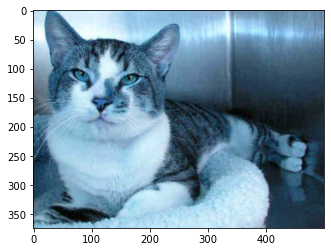

{'result': 'cat', 'logit': -15.027936}


In [38]:
import random

test_dir_path = "../../Dataset/Cat_and_Dog/test/test1/"

# pick one image / or directly name this filename
chosen_index = random.randint(0,1000)

# use custom path
test_img_path = test_dir_path+os.listdir(test_dir_path)[chosen_index]

# plot the image
test_img = cv.imread(test_img_path)
plt.imshow(test_img)
plt.show()

# preprocess the image
test_img_numpy = tran_dataset.__preprocess__(test_img_path)

#  convert data type from numpy to tensor
test_img_tensor = torch.tensor(test_img_numpy).to(device)

# add the dim as the batch
test_img_tensor = torch.unsqueeze(test_img_tensor, 0).float()

with torch.no_grad():
    logit = CNN_model(test_img_tensor)
    logit = logit.cpu().numpy()[0][0]
    if logit > 0:
        result = {"result": "dog", "logit": logit}
    else:
        result = {"result": "cat", "logit": logit}
    
    print(result)